
## Speech Recognition with Neural Networks


### Introduction  

In this notebook builds a deep neural network that functions as part of an end-to-end automatic speech recognition (ASR) pipeline! The pipeline will accept raw audio as input and return a predicted transcription of the spoken language.  The full pipeline is summarized in the figure below.

<img src="images/VUI flow.png">

- **STEP 1** is a pre-processing step that converts raw audio to one of two feature representations that are commonly used for ASR. 
- **STEP 2** is an acoustic model which accepts audio features as input and returns a probability distribution over all potential transcriptions.  
- **STEP 3** is a character-based language models is their small vocabulary and exibility in handling any words, punctuation, and other document structure.
- **STEP 4** in the pipeline takes the output from the acoustic model and returns a predicted transcription.  

In [1]:
from data_generator import vis_train_features

# extract label and audio features for a single training example
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()

There are 9557 total training examples.


Visualizes the audio waveform for your chosen example, along with the corresponding transcript.

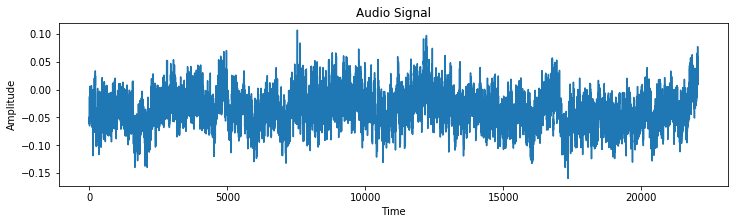

**Shape of Audio Signal** : (22050,)

**Transcript** : five

In [2]:
from IPython.display import Markdown, display
from data_generator import vis_train_features, plot_raw_audio
from IPython.display import Audio
%matplotlib inline

plot_raw_audio(vis_raw_audio)
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
display(Markdown('**Transcript** : ' + str(vis_text)))
Audio(vis_audio_path)

<a id='step1'></a>
## 1: Feature Extraction.
### Spectrograms

The first option for an audio feature representation. The code for calculating the spectrogram was borrowed from [this repository](https://github.com/baidu-research/ba-dls-deepspeech).  The implementation appears in the `utils.py` file. The code returns the spectrogram as a 2D tensor, where the first (_vertical_) dimension indexes time, and the second (_horizontal_) dimension indexes frequency.

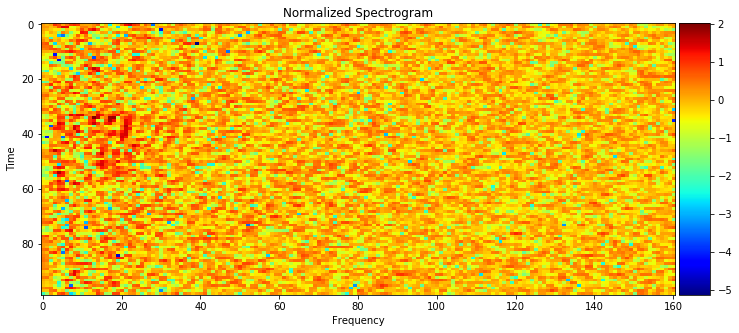

**Shape of Spectrogram** : (99, 161)

In [3]:
from data_generator import plot_spectrogram_feature

plot_spectrogram_feature(vis_spectrogram_feature)
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

### Mel-Frequency Cepstral Coefficients (MFCCs)

The second option for an audio feature representation is [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum). The main idea behind MFCC features is the same as spectrogram features: at each time window, the MFCC feature yields a feature vector that characterizes the sound within the window.  Note that the MFCC feature is much lower-dimensional than the spectrogram feature. 

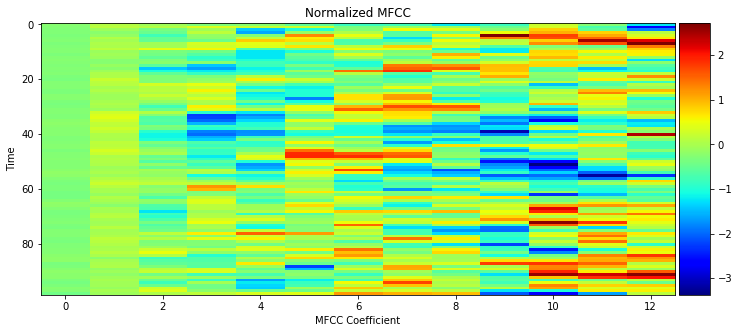

**Shape of MFCC** : (99, 13)

In [4]:
from data_generator import plot_mfcc_feature

plot_mfcc_feature(vis_mfcc_feature)
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

<a id='step2'></a>
## 2: Recurent Neural Networks for Acoustic Modeling


We begin by training some architectures. All models will be specified in the `sample_models.py` file. 

In [4]:
###### RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK ######

from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 1.0
set_session(tf.Session(config=config))

# Re-import for changes 
%load_ext autoreload
%autoreload 2
from sample_models import *
from train_utils import train_model

Using TensorFlow backend.
/data/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Colocations handled automatically by placer.


<a id='model0'></a>
### Simple RNN

<img src="images/simple rnn.png" width="70%">

At each time step, the speaker pronounces one of 28 possible characters, including each of the 26 letters in the English alphabet, along with a space character (" "), and an apostrophe (').

The output of the RNN at each time step is a vector of probabilities with 29 entries, where the $i$-th entry encodes the probability that the $i$-th character is spoken in the time sequence.  

In [2]:
model_0 = simple_rnn_model(input_dim=13) # change to 13 if you would like to use MFCC features

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn (GRU)                    (None, None, 29)          3741      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 3,741
Trainable params: 3,741
Non-trainable params: 0
_________________________________________________________________
None


The cell below will train the acoustic model with the [CTC loss](http://www.cs.toronto.edu/~graves/icml_2006.pdf) criterion. The CTC loss function was implemented at`add_ctc_loss` function within the `train_utils.py` file in the repository.

To train your architecture, you will use the `train_model` function within the `train_utils` module; it has already been imported in one of the above code cells.  The `train_model` function takes three **required** arguments:
- `input_to_softmax` - a Keras model instance.
- `pickle_path` - the name of the pickle file where the loss history will be saved.
- `save_model_path` - the name of the HDF5 file where the model will be saved.

You may notice that the loss quickly becomes undefined (`nan`) - This is due to the [exploding gradients problem](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/). Consider adjust the clipping argument in the`train_model` function [gradient clipping](https://arxiv.org/pdf/1211.5063.pdf).

In [3]:
train_model(input_to_softmax=model_0, 
            pickle_path='model_0.pickle', 
            save_model_path='model_0.h5',
            spectrogram=False) # change to False if you would like to use MFCC features

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/20
477/477 [==============================] - 78s - loss: 151.8621 - val_loss: 147.5465
Epoch 2/20
477/477 [==============================] - 77s - loss: 147.4868 - val_loss: 147.4368
Epoch 3/20
477/477 [==============================] - 77s - loss: 147.3980 - val_loss: 147.3619
Epoch 4/20
477/477 [==============================] - 77s - loss: 147.3328 - val_loss: 147.3076
Epoch 5/20
477/477 [==============================] - 77s - loss: 147.2893 - val_loss: 147.2838
Epoch 6/20
477/477 [==============================] - 77s - loss: 147.2630 - val_loss: 147.2492
Epoch 7/20
477/477 [==============================] - 77s - loss: 147.2513 - val_loss: 147.2341
Epoch 8/20
477/477 [==============================] - 78s - loss: 147.2446 - val_loss: 147.2418
Epoch 9/20
477/477 [==============================] - 78s 

<a id='model1'></a>
### RNN + TimeDistributed Dense

The [TimeDistributed](https://keras.io/layers/wrappers/) wrapper and the [BatchNormalization](https://keras.io/layers/normalization/) layer in the Keras documentation.[batch normalization] (https://arxiv.org/pdf/1510.01378.pdf) Added to the recurrent layer to reduce training times.  The `TimeDistributed` layer will be used to find more complex patterns in the dataset.  The unrolled snapshot of the architecture is depicted below.

<img src="images/Rnn TD.png" width="70%">


In [11]:
model_1 = rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                    units=100,
                    activation='relu')

/data/home/nsnam/vui/sample_models.py:29: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(100, activation="relu", recurrent_dropout=0.1, name="rnn", dropout=0.0, implementation=2, return_sequences=True)`
  return_sequences=True, implementation=2, name='rnn',dropout_W=0.0, dropout_U=0.1)(input_data)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn (GRU)                    (None, None, 100)         34200     
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 100)         400       
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 29)          2929      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 37,529
Trainable params: 37,329
Non-trainable params: 200
_________________________________________________________________
None


In [12]:
from keras.optimizers import SGD

train_model(input_to_softmax=model_1, 
            pickle_path='model_1.pickle', 
            save_model_path='model_1.h5',
            spectrogram=False,                 # change to False if you would like to use MFCC features
            optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=0.5),
            epochs=5) 

Epoch 1/5
477/477 [==============================] - 82s - loss: 53.6990 - val_loss: 125.4595
Epoch 2/5
477/477 [==============================] - 80s - loss: 11.9944 - val_loss: 10.4319
Epoch 3/5
477/477 [==============================] - 80s - loss: 7.5895 - val_loss: 11.1432
Epoch 4/5
477/477 [==============================] - 81s - loss: 6.9412 - val_loss: 12.0715
Epoch 5/5
477/477 [==============================] - 82s - loss: 6.3842 - val_loss: 12.8469


<a id='model2'></a>
### CNN + RNN + TimeDistributed Dense

The architecture in `cnn_rnn_model` adds an additional level of complexity, by introducing a [1D convolution layer](https://keras.io/layers/convolutional/#conv1d) Also has other name as Time Convolution layer.  

<img src="images/Cnn Rnn TD.png" width="70%">


In [7]:
model_2 = cnn_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=100,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 100)         177200    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 100)         400       
_________________________________________________________________
rnn (GRU)                    (None, None, 100)         60300     
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 100)         400       
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 29)          2929      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [8]:
from keras.optimizers import SGD

train_model(input_to_softmax=model_2, 
            pickle_path='model_2.pickle', 
            save_model_path='model_2.h5', 
            spectrogram=True,       # change to False if you would like to use MFCC features
            optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=0.5)) 

Epoch 1/20
477/477 [==============================] - 44s - loss: 35.9283 - val_loss: 36.2581
Epoch 2/20
477/477 [==============================] - 41s - loss: 21.4985 - val_loss: 94.8247
Epoch 3/20
477/477 [==============================] - 42s - loss: 10.7204 - val_loss: 105.2569
Epoch 4/20
477/477 [==============================] - 42s - loss: 5.5957 - val_loss: 42.4147
Epoch 5/20
477/477 [==============================] - 41s - loss: 2.9781 - val_loss: 51.3177
Epoch 6/20
477/477 [==============================] - 42s - loss: 1.7288 - val_loss: 48.8525
Epoch 7/20
477/477 [==============================] - 41s - loss: 1.0811 - val_loss: 80.6105
Epoch 8/20
477/477 [==============================] - 41s - loss: 0.7208 - val_loss: 80.0778
Epoch 9/20
477/477 [==============================] - 41s - loss: 0.4907 - val_loss: 63.8901
Epoch 10/20
477/477 [==============================] - 41s - loss: 0.3926 - val_loss: 63.9679
Epoch 11/20
477/477 [==============================] - 41s - loss

<a id='model3'></a>
### Deeper RNN + TimeDistributed Dense

<img src="images/deeper rnn.png" width="70%">


In [5]:
model_3 = deep_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                         units=50,
                         recur_layers=2) 

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn0 (GRU)                   (None, None, 50)          31800     
_________________________________________________________________
bn_rnn0 (BatchNormalization) (None, None, 50)          200       
_________________________________________________________________
rnn1 (GRU)                   (None, None, 50)          15150     
_________________________________________________________________
bn_rnn1 (BatchNormalization) (None, None, 50)          200       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          1479   

In [4]:
from keras.optimizers import SGD

train_model(input_to_softmax=model_3, 
            pickle_path='model_3.pickle', 
            save_model_path='model_3.h5', 
            spectrogram=True,       # change to False if you would like to use MFCC features
            optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=0.7)) 

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/20
477/477 [==============================] - 185s - loss: 76.5610 - val_loss: 142.3095
Epoch 2/20
477/477 [==============================] - 142s - loss: 15.3003 - val_loss: 14.8526
Epoch 3/20
477/477 [==============================] - 141s - loss: 8.0584 - val_loss: 14.7419
Epoch 4/20
477/477 [==============================] - 141s - loss: 6.6337 - val_loss: 16.8169
Epoch 5/20
477/477 [==============================] - 140s - loss: 5.3201 - val_loss: 20.2821
Epoch 6/20
477/477 [==============================] - 140s - loss: 4.3683 - val_loss: 23.6150
Epoch 7/20
477/477 [==============================] - 140s - loss: 3.8907 - val_loss: 23.2390
Epoch 8/20
477/477 [==============================] - 140s - loss: 3.5295 - val_loss: 22.8421
Epoch 9/20
477/477 [==============================] - 140s - loss: 3.32

<a id='model4'></a>
### Bidirectional RNN + TimeDistributed Dense

[Bidirectional](https://keras.io/layers/wrappers/) wrapper in the Keras documentation. This cell uses a single bidirectional RNN layer, before a (`TimeDistributed`) dense layer.  The added value of a bidirectional RNN is described well in [this paper](http://www.cs.toronto.edu/~hinton/absps/DRNN_speech.pdf).
One shortcoming of conventional RNNs is that they are only able to make use of previous context. In speech recognition, where whole utterances are transcribed at once, there is no reason not to exploit future context as well.  Bidirectional RNNs (BRNNs) do this by processing the data in both directions with two separate hidden layers which are then fed forwards to the same output layer.

<img src="images/bidirectional rnn.png" width="70%">


In [15]:
model_4 = bidirectional_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                                  units=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, None, 100)         63600     
_________________________________________________________________
time_distributed_9 (TimeDist (None, None, 29)          2929      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 66,529
Trainable params: 66,529
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
from keras.optimizers import SGD

train_model(input_to_softmax=model_4, 
            pickle_path='model_4.pickle', 
            save_model_path='model_4.h5', 
            spectrogram=True,       # change to False if you would like to use MFCC features
            optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=0.7)) 

Epoch 1/20
477/477 [==============================] - 134s - loss: 31.9567 - val_loss: 41.1723
Epoch 2/20
477/477 [==============================] - 131s - loss: 9.4899 - val_loss: 14.4821
Epoch 3/20
477/477 [==============================] - 130s - loss: 6.4687 - val_loss: 20.5238
Epoch 4/20
477/477 [==============================] - 130s - loss: 5.2757 - val_loss: 26.2519
Epoch 5/20
477/477 [==============================] - 131s - loss: 4.5190 - val_loss: 32.3310
Epoch 6/20
477/477 [==============================] - 131s - loss: 3.9627 - val_loss: 35.5410
Epoch 7/20
477/477 [==============================] - 131s - loss: 3.5521 - val_loss: 33.9494
Epoch 8/20
477/477 [==============================] - 129s - loss: 3.1824 - val_loss: 35.5557
Epoch 9/20
477/477 [==============================] - 129s - loss: 2.8618 - val_loss: 36.2265
Epoch 10/20
477/477 [==============================] - 129s - loss: 2.5460 - val_loss: 35.7700
Epoch 11/20
477/477 [==============================] - 129

<a id='compare'></a>
### Compare the Models


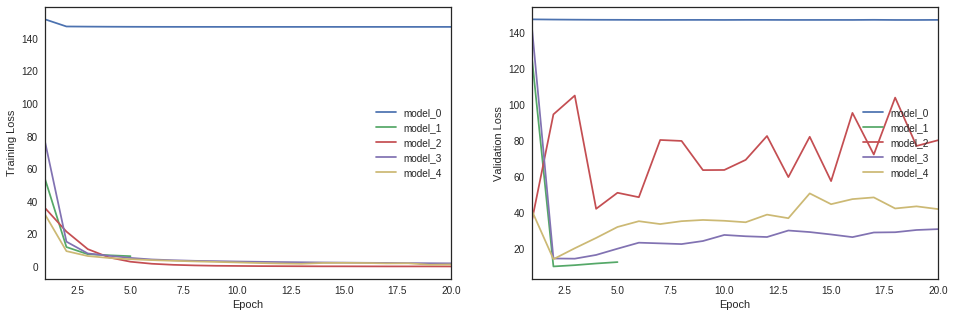

In [21]:
from glob import glob
import numpy as np
import _pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')

# obtain the paths for the saved model history
all_pickles = sorted(glob("results/*.pickle"))
# extract the name of each model
model_names = [item[8:-7] for item in all_pickles]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

## 3: Todo: Add Character Based Language Model

<a id='step3'></a>
## 4: Obtain Predictions
Decode the predictions of your acoustic model.  Output of softmax  represent the probability distribuition function 

<img src="images/pdf.png" width="70%">


In [14]:
import numpy as np
from data_generator import AudioGenerator
from keras import backend as K
from utils import int_sequence_to_text
from IPython.display import Audio

def get_predictions(index, partition, input_to_softmax, model_path):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator(spectrogram=True)
    data_gen.load_train_data()
    data_gen.load_validation_data()
    
    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
    
    # play the audio file, and display the true and predicted transcriptions
    print('-'*80)
    Audio(audio_path)
    print('True transcription:\n' + '\n' + transcr)
    print('-'*80)
    print('Predicted transcription:\n' + '\n' + ''.join(int_sequence_to_text(pred_ints)))
    print('-'*80)

In [28]:
get_predictions(index=1, 
                partition='train',
                input_to_softmax=deep_rnn_model(
                         input_dim=161, # change to 13 if you would like to use MFCC features
                         units=50,
                         recur_layers=2), 
                model_path='results/model_3.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn0 (GRU)                   (None, None, 50)          31800     
_________________________________________________________________
bn_rnn0 (BatchNormalization) (None, None, 50)          200       
_________________________________________________________________
rnn1 (GRU)                   (None, None, 50)          15150     
_________________________________________________________________
bn_rnn1 (BatchNormalization) (None, None, 50)          200       
_________________________________________________________________
time_distributed_17 (TimeDis (None, None, 29)          1479      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

### Visualize the output probabilitiy distribution.

In [22]:
"""
Use this script to visualize the output of a trained speech-model.
Usage: python visualize.py /path/to/audio /path/to/training/json.json \
            /path/to/model
"""

from __future__ import absolute_import, division, print_function
import argparse
#import matplotlib
#matplotlib.use('Agg')
#import matplotlib.pyplot as plt
import numpy as np

from data_generator import AudioGenerator
#from utils import argmax_decode, load_model


def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)


def visualize(model, test_file, train_desc_file):
    """ Get the prediction using the model, and visualize softmax outputs
    Params:
        model (keras.models.Model): Trained speech model
        test_file (str): Path to an audio clip
        train_desc_file(str): Path to the training file used to train this
                              model
    """
    datagen = AudioGenerator()
    datagen.load_train_data()
    #datagen.fit_train(100)

    inputs = data_gen.normalize(datagen.featurize(test_file))
    print(inputs.shape)
    prediction = np.squeeze(model.predict(np.expand_dims(inputs, axis=0)))
    softmax_file = "softmax.npy".format(test_file)
    softmax_img_file = "softmax.png".format(test_file)
    '''print ("Prediction: {}"
           .format(argmax_decode(prediction)))
    print ("Saving network output to: {}".format(softmax_file))
    print ("As image: {}".format(softmax_img_file))
    '''
    np.save(softmax_file, prediction)
    sm = softmax(prediction.T)
    print(sm.shape)
    sm = np.vstack((sm[0],sm[1], sm[2:][::-1]))
    print(sm.shape)
    fig, ax = plt.subplots(figsize=(15,10))
    ax.pcolor(sm, cmap=plt.cm.Greys_r)
    column_labels =  [chr(i) for i in range(97, 97 + 26)] + ['space','blank']
    ax.margins(x=0, y=0.5)
    ax.set_yticks(np.arange(sm.shape[0])+1.5, minor=False)
    ax.set_yticklabels(column_labels[::-1], minor=False)
    plt.show()
    #plt.savefig(softmax_img_file)


five
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn0 (GRU)                   (None, None, 50)          31800     
_________________________________________________________________
bn_rnn0 (BatchNormalization) (None, None, 50)          200       
_________________________________________________________________
rnn1 (GRU)                   (None, None, 50)          15150     
_________________________________________________________________
bn_rnn1 (BatchNormalization) (None, None, 50)          200       
_________________________________________________________________
time_distributed_18 (TimeDis (None, None, 29)          1479      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total

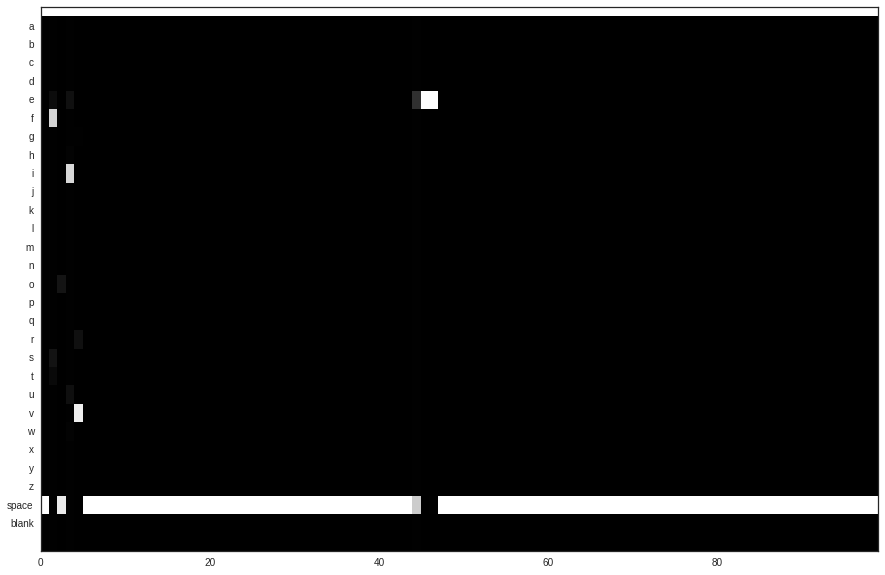

In [29]:
    data_gen = AudioGenerator()
    data_gen.load_train_data()
    print(data_gen.train_texts[1])
    test_file = data_gen.train_audio_paths[1]
    model=deep_rnn_model(
                         input_dim=161, # change to 13 if you would like to use MFCC features
                         units=50,
                         recur_layers=2)
    model_path='results/model_3.h5'
    model.load_weights(model_path)
    train_desc_file = ""
    visualize(model, test_file, train_desc_file)
    